# Pima Indians Diabetes ML and DeepL Model Development - Tiago Pereira

## Importing the libraries

In [126]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import KNNImputer

## 1. Importing the dataset (Data Preparation)

In [127]:
df = pd.read_csv('diabetes.csv')

### Inspect the Dataset (Sample of 10 values)

In [128]:
df.shape

(768, 9)

As we can see, this dataset have 768 observations (we can consider that has a small amount of samples), and also have 9 columns (8 feature variables and 1 target variable aka outcome).

In [129]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


### Check for and handle missing values

In [130]:
# Define columns where 0 likely means "missing"
cols_with_missing_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Count zeros in each of those columns
missing_counts = (df[cols_with_missing_zeros] == 0).sum()

# Display the possible missing values
print("🔍 Possible Missing Values (zeros):")
print(missing_counts)

# Output for checking with actual NaNs values (just in case)
print("\n🧼 True Missing Values (NaN):")
print(df.isnull().sum())


🔍 Possible Missing Values (zeros):
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

🧼 True Missing Values (NaN):
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


As we can see on the <i>Possible Missing Values</i> info, some features in the pima indians diabetes dataset like <b>Glucose</b>, <b>BloodPressure</b>, <b>SkinThickness</b>, <b>Insulin</b> and <b>BMI</b> contain zero values that aren't technically missing, but they are biologically implausible, where a person with level 0 of glucose isn't physiologically possible and also a person with the BMI value of 0 doesn't make sense.

These are likely data entry errors or placeholders for missing values, and they will distort your model's learning performance and also they are a lot of data points to remove from your dataset, only have about 768 observations on this, so we think aren't good idea to discard this entries, so we suggest replace then with NaN values and switch by impute missing values using the technique <b>Median Imputation</b> and/or <b>KNN Imputer</b>.

We choose apply <b><i>Median Imputation for the XGBoost model</b></i>, because they fit better for tree-based models (like <b>XGBoost</b>), which are less sensitive to imputation methods, very fast and easy to implement, robust to outliers, doesn’t introduce artificial correlations and the dataset is small like this one, doesn’t introduce artificial correlations, on the other hand we choose the <b><i>KNN Inputer technique for the ANN aplication</b></i>, because they preserving feature relationships and improving ANN performance, uses patterns in the data to estimate missing values, preserves multivariate structure (important for ANNs), can improve performance on models sensitive to feature interactions, we want to preserve subtle feature interactions.


In [131]:
df_cleaned_xgb = df.copy()
df_cleaned_xgb[cols_with_missing_zeros] = df_cleaned_xgb[cols_with_missing_zeros].replace(0, np.nan)

### Apply Median Imputation (recommended for skewed data) on the dataset only to use for training XGBoost Model (tree-based model choosed)

In [132]:
df_cleaned_xgb[cols_with_missing_zeros] = df_cleaned_xgb[cols_with_missing_zeros].fillna(
    df_cleaned_xgb[cols_with_missing_zeros].median()
)

### Rectify if zeros still appear after applying the Median Imputation and KNN Imputer

In [133]:
# Count zeros in each of those columns
missing_counts = (df_cleaned_xgb[cols_with_missing_zeros] == 0).sum()

# Display the possible missing values
print("🔍 Median Imputation Possible Missing Values (zeros):")
print(missing_counts)

🔍 Median Imputation Possible Missing Values (zeros):
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64


### Correlation Matrix for the dataset - goal to understand how features relate to each other and with your target variable (outcome)

/var/folders/1j/jpfyj3rs4nv6n17cprwxw5n40000gn/T/ipykernel_10785/9922934.py:8: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


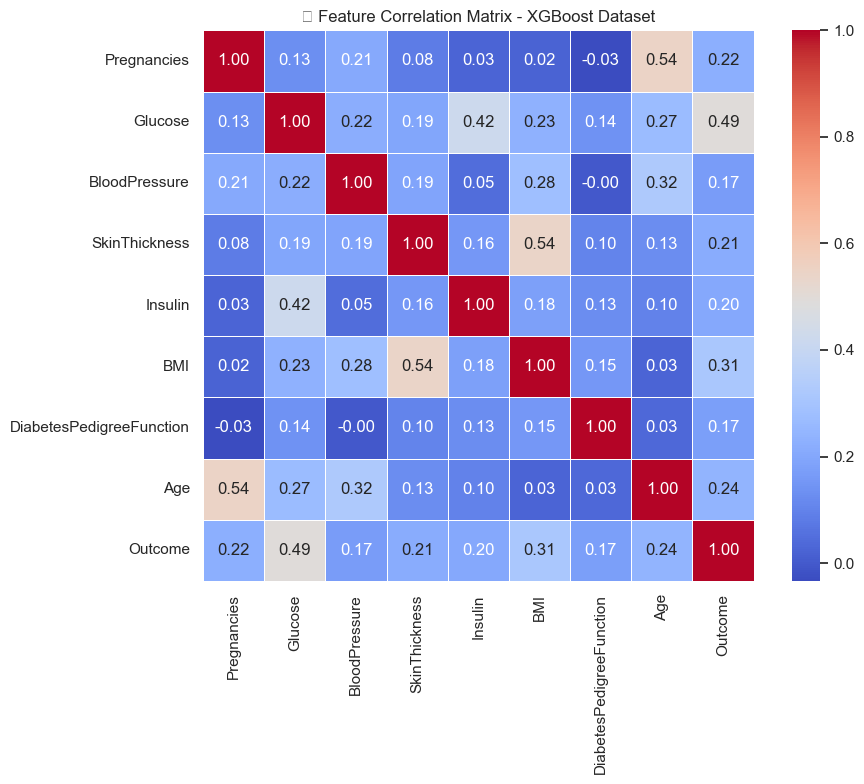

In [134]:
# Get the Correlation Matrix based on the df with the cleaned missing values (XGBoost)
corr_matrix_xgb = df_cleaned_xgb.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_xgb, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("🔍 Feature Correlation Matrix - XGBoost Dataset")
plt.tight_layout()
plt.show()


### Split into training and test sets (e.g., 70/30, stratified by outcome)

#### Dataset cleaned with the application of Median Imputation (to fix missing values on the features: Glucose, BloodPressure, SkinThickness, Insulin and BMI) only applied to the XGBoost Model

In [135]:
# Split dataset by features and target
X = df_cleaned_xgb.drop('Outcome', axis=1)
y = df['Outcome']

# Split data into train (70%) and test (30%) with stratify, 
# this ensures both sets have similar proportions of diabetes-positive/negative cases
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Check the shape of the splits (Train and Test)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples\n")
print(f"Training Outcome distribution:\n{y_train.value_counts(normalize=True)}\n")
print(f"Test Outcome distribution:\n{y_test.value_counts(normalize=True)}")

Training set size: 537 samples
Test set size: 231 samples

Training Outcome distribution:
Outcome
0    0.651769
1    0.348231
Name: proportion, dtype: float64

Test Outcome distribution:
Outcome
0    0.649351
1    0.350649
Name: proportion, dtype: float64


In [136]:
print(X_train)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
209            7    184.0           84.0           33.0    125.0  35.5   
176            6     85.0           78.0           29.0    125.0  31.2   
147            2    106.0           64.0           35.0    119.0  30.5   
454            2    100.0           54.0           28.0    105.0  37.8   
636            5    104.0           74.0           29.0    125.0  28.8   
..           ...      ...            ...            ...      ...   ...   
214            9    112.0           82.0           32.0    175.0  34.2   
113            4     76.0           62.0           29.0    125.0  34.0   
556            1     97.0           70.0           40.0    125.0  38.1   
759            6    190.0           92.0           29.0    125.0  35.5   
107            4    144.0           58.0           28.0    140.0  29.5   

     DiabetesPedigreeFunction  Age  
209                     0.355   41  
176                     0.382   42  


In [137]:
print(y_train)

209    1
176    0
147    0
454    0
636    0
      ..
214    1
113    0
556    0
759    1
107    0
Name: Outcome, Length: 537, dtype: int64


In [138]:
print(X_test)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
730            3    130.0           78.0           23.0     79.0  28.4   
198            4    109.0           64.0           44.0     99.0  34.8   
24            11    143.0           94.0           33.0    146.0  36.6   
417            4    144.0           82.0           32.0    125.0  38.5   
387            8    105.0          100.0           36.0    125.0  43.3   
..           ...      ...            ...            ...      ...   ...   
94             2    142.0           82.0           18.0     64.0  24.7   
437            5    147.0           75.0           29.0    125.0  29.9   
86            13    106.0           72.0           54.0    125.0  36.6   
221            2    158.0           90.0           29.0    125.0  31.6   
19             1    115.0           70.0           30.0     96.0  34.6   

     DiabetesPedigreeFunction  Age  
730                     0.323   34  
198                     0.905   26  


In [139]:
print(y_test)

730    1
198    1
24     1
417    1
387    1
      ..
94     0
437    0
86     0
221    1
19     1
Name: Outcome, Length: 231, dtype: int64


### Feature Scaling (Normalize features - important for ANN but we also consider this technique to apply on the XGBoost Model, even though there is not so much need to apply this on that)

In [140]:
# Initialize the scaler and fit only on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [141]:
print(X_train_scaled)

[[ 0.93138344  2.08649132  0.96693912 ...  0.42891002 -0.37477883
   0.63212912]
 [ 0.63260632 -1.22191175  0.47413971 ... -0.21055029 -0.29416766
   0.71699246]
 [-0.56250219 -0.52012928 -0.67572557 ... -0.31464848  2.74517192
   0.03808578]
 ...
 [-0.86127931 -0.82089319 -0.18292616 ...  0.81556043 -0.78380586
  -0.30136756]
 [ 0.63260632  2.2870006   1.62400499 ...  0.42891002 -0.60466993
   2.75371249]
 [ 0.03505207  0.74976281 -1.16852497 ... -0.46336018 -0.57779954
   0.29267578]]


In [142]:
print(X_test_scaled)

[[-0.26372506  0.28190783  0.47413971 ... -0.62694304 -0.47031799
   0.03808578]
 [ 0.03505207 -0.41987464 -0.67572557 ...  0.32481183  1.26730051
  -0.6408209 ]
 [ 2.12649194  0.7163446   1.78827146 ...  0.59249289 -0.6763243
   1.48076247]
 ...
 [ 2.7240462  -0.52012928 -0.01865969 ...  0.59249289 -0.90322981
   0.97158246]
 [-0.56250219  1.21761779  1.45973853 ... -0.15106561  0.96874063
   2.75371249]
 [-0.86127931 -0.21936536 -0.18292616 ...  0.29506949  0.14471537
  -0.13164089]]


StandardScaler transforms the data to have zero mean and to get the unit variance. Only apply the fitting on the training set to avoid data leakage into the test set. <br>
Next code we could view the scaled feature means and std deviations, will take back a dataframe to show this on the training scaled set.

In [143]:
# Get back to DataFrame for better readability on the features
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Output the means and also the std deviations by each feature
print(X_train_scaled_df.describe().loc[['mean', 'std']])

       Pregnancies       Glucose  BloodPressure  SkinThickness       Insulin  \
mean  2.315549e-17  1.984756e-17  -2.613262e-16   1.902058e-16 -4.631098e-17   
std   1.000932e+00  1.000932e+00   1.000932e+00   1.000932e+00  1.000932e+00   

               BMI  DiabetesPedigreeFunction           Age  
mean  1.111463e-15              1.190854e-16 -2.117073e-16  
std   1.000932e+00              1.000932e+00  1.000932e+00  


## 2. Tree-Based Models (Random Forest / XGBoost)

## Train a baseline model using Random Forest or XGBoost

In [144]:
from xgboost import XGBClassifier

# Define the model (Using XGBoost)
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

# Calculate scale to determinate more costly ratio for Diabetic samples (penalizing the model on this way)
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale = neg / pos
print(f'scale_pos_weight = {scale:.2f}')

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 150, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1.0, 1.5, scale, 2.5]
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit on training data (scaled data only on the features training set)
grid_search.fit(X_train_scaled, y_train)

# Best parameters and estimator
print('\n')
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Recall Score (CV): {grid_search.best_score_:.4f}')
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict and evaluate based on the best model
y_pred = best_model.predict(X_test_scaled)
# XGBoost predicted probabilities
y_scores_xgb = best_model.predict_proba(X_test_scaled)[:,1]

# Metrics calculation for Accuracy, Precision, Recall, F1 Score
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred)
}

# Metrics Result Output
print(f"✅ Accuracy:  {metrics['Accuracy']:.4f}")
print(f"🎯 Precision: {metrics['Precision']:.4f}")
print(f"🔁 Recall:    {metrics['Recall']:.4f}")
print(f"📏 F1 Score:  {metrics['F1 Score']:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Non-Diabetic', 'Diabetic']))

scale_pos_weight = 1.87
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 2.5, 'subsample': 1.0}
Best Recall Score (CV): 0.8284
✅ Accuracy:  0.7576
🎯 Precision: 0.6068
🔁 Recall:    0.8765
📏 F1 Score:  0.7172

Classification Report:

              precision    recall  f1-score   support

Non-Diabetic       0.91      0.69      0.79       150
    Diabetic       0.61      0.88      0.72        81

    accuracy                           0.76       231
   macro avg       0.76      0.78      0.75       231
weighted avg       0.81      0.76      0.76       231



In [145]:
y_scores_xgb = best_model.predict_proba(X_test_scaled)[:,1]
# XGBoost predictions (default threshold 0.5)
y_pred_xgb = (y_scores_xgb >= 0.5).astype(int)
print(f"Outcome Predictions (Non-Diabetics cases) for XGBoost Model: {(y_pred_xgb == 0).sum()}")
print(f"Outcome Predictions (Diabetics cases) for XGBoost Model: {(y_pred_xgb == 1).sum()}")


Outcome Predictions (Non-Diabetics cases) for XGBoost Model: 114
Outcome Predictions (Diabetics cases) for XGBoost Model: 117


#### Plot XGBoost Feature Importance

/var/folders/1j/jpfyj3rs4nv6n17cprwxw5n40000gn/T/ipykernel_10785/2559397714.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
/var/folders/1j/jpfyj3rs4nv6n17cprwxw5n40000gn/T/ipykernel_10785/2559397714.py:15: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


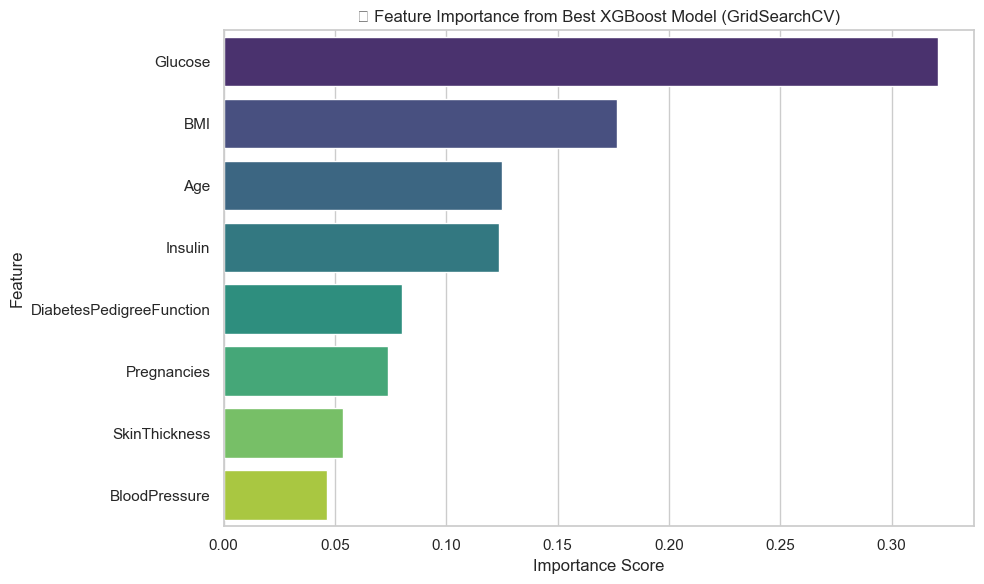

In [146]:
# Get feature importances
importances = best_model.feature_importances_
features = X.columns

# Create DataFrame
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("🌟 Feature Importance from Best XGBoost Model (GridSearchCV)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


|Feature	|Importance Score |	Interpretation |
| :-------: | :-------------: | :-------------:
|Glucose	|~0.32	| Most influential predictor
|BMI	|~0.15	|Strong contributor
|Age	|~0.10	|Important demographic factor
|Insulin	|~0.08	|Moderate influence
|DiabetesPedigreeFunction	|~0.07	|Genetic risk factor
|Pregnancies	|~0.06	|Mild influence
|SkinThickness	|~0.05	|Lower impact
|BloodPressure	|~0.03	|Least influential

<br>

<b><i>Interpretation details:</b></i>

1. <b>Glucose is the most important</b>

 - With a score of <b>~0.32</b>, Glucose is by far the most important feature.

 - This aligns with clinical knowledge: high glucose levels are a primary indicator of diabetes.

 2. <b>BMI and Age matter</b>

 - BMI reflects body fat, which is a known risk factor.

 - Age contributes to risk, especially in older individuals.

 3. <b>Insulin & Pedigree Function</b>

 - These features capture metabolic and genetic risk.

 - Their moderate importance suggests they add value, but not as much as Glucose or BMI.

4. <b>Pregnancies, SkinThickness, BloodPressure</b>

 - These features have lower importance, but still contribute.

 - They may interact with other features in subtle ways.


The XGBoost model is relying most heavily on features like <b>Glucose, BMI, and Age</b> which is both statistically and medically sound.

The model is interpretable and aligned with domain knowledge, which is great for trust and transparency, we choose to consider all the features to apply the model, but we could just focusing on the <b>Glucose, BMI, Age, Insulin and Pedigree Function/Pregnancies.</b>

#### Plot SHAP (SHapley Additive exPlanations)

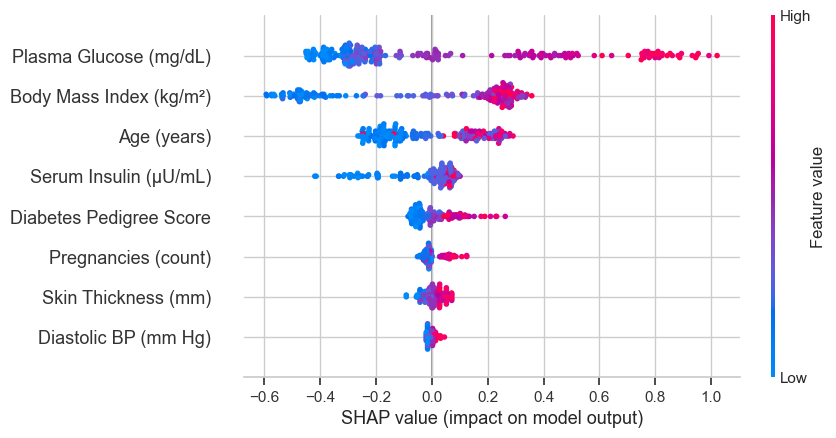

In [147]:
# Label the features for the SHAP plot
feature_labels = {
    "Pregnancies": "Pregnancies (count)",
    "Glucose": "Plasma Glucose (mg/dL)",
    "BloodPressure": "Diastolic BP (mm Hg)",
    "SkinThickness": "Skin Thickness (mm)",
    "Insulin": "Serum Insulin (μU/mL)",
    "BMI": "Body Mass Index (kg/m²)",
    "DiabetesPedigreeFunction": "Diabetes Pedigree Score",
    "Age": "Age (years)"
}

# Switch the name on the X_test_scaled
X_test_scaled_labeled = X_test_scaled.copy()
X_test_scaled_labeled = pd.DataFrame(X_test_scaled, columns=[feature_labels.get(col, col) for col in X.columns])

# Load the explainer for tree-based models like XGBoost
explainer = shap.Explainer(best_model, X_test_scaled_labeled)

# Compute SHAP values for the test set
shap_values = explainer(X_test_scaled_labeled)

shap.plots.beeswarm(shap_values, max_display=10)

This plot above shows how each feature influences the model's predictions across all samples in this case when we apply the XGBoost model.
The Y-axis shows the features ranked by importance, where the features that appear on the top are the most impactful and on the X-axis we got the <b>SHAP values</b> that have impact on the model, where <b><i>values > 0</b></i> pushes the prediction toward <u>diabetic</u> and <b><i>values < 0</b></i> pushes prediction toward <u>non-diabetic</u>, also the <i>red color represent high feature value and blue ones shows the lowest feature values</i>.

#### Features Key Insights from SHAP plot:

1. Plasma Glucose (mg/dL) - Most influential feature

 - High glucose (red) strongly pushes predictions toward diabetes;

 - Low glucose (blue) pushes toward non-diabetic.

2. Body Mass Index (BMI)

 - High BMI increases diabetes risk;

 - Low BMI reduces it;

 - Consistent with medical knowledge.

3. Age (years)

 - Older individuals (red) are more likely to be predicted diabetic;

 - Younger individuals (blue) reduce the prediction.

4. Serum Insulin (µU/mL)

 - More complex pattern—both high and low values have mixed effects;

 - Could indicate non-linear relationships.

5. Diabetes Pedigree Score

- Higher scores (red) increase risk;

- Reflects genetic predisposition.

6. Pregnancies (count)

- More pregnancies slightly increase risk;

- Likely due to gestational diabetes risk.

7. Skin Thickness & Diastolic BP

 - Least impactful features in this model;

 - May be less predictive or noisy in this dataset.


We can consider your model medically sensibly to features like: <b>Glucose, BMI and Age.</b>
This tell us that <b>high values of these features push predictions toward diabetes cases</b> otherwise features like <b>Skin Thickness</b> and <b>Blood Pressure</b> <b>have minimal influence in your model</b>.

#### Bar Plot of the Best Parameters for the XGBoost Model

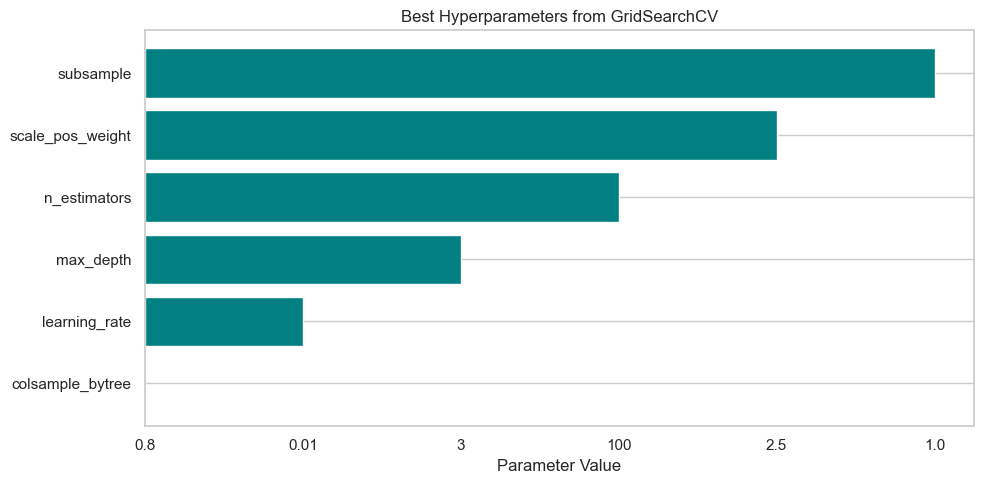

In [148]:
# Plot
plt.figure(figsize=(10, 5))
plt.barh(list(best_params.keys()), [str(v) for v in best_params.values()], color='teal')
plt.title("Best Hyperparameters from GridSearchCV")
plt.xlabel("Parameter Value")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

As we can see above, these are the best values of the Hyperparameters from GridSearchCV, with the values:

 - subsample: 1.0
 - scale_pos_weight: 2.5
 - n_estimators: 100
 - max_depth: 3
 - learning_rate: 0.01
 - colsample_bytree: 0.8


/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


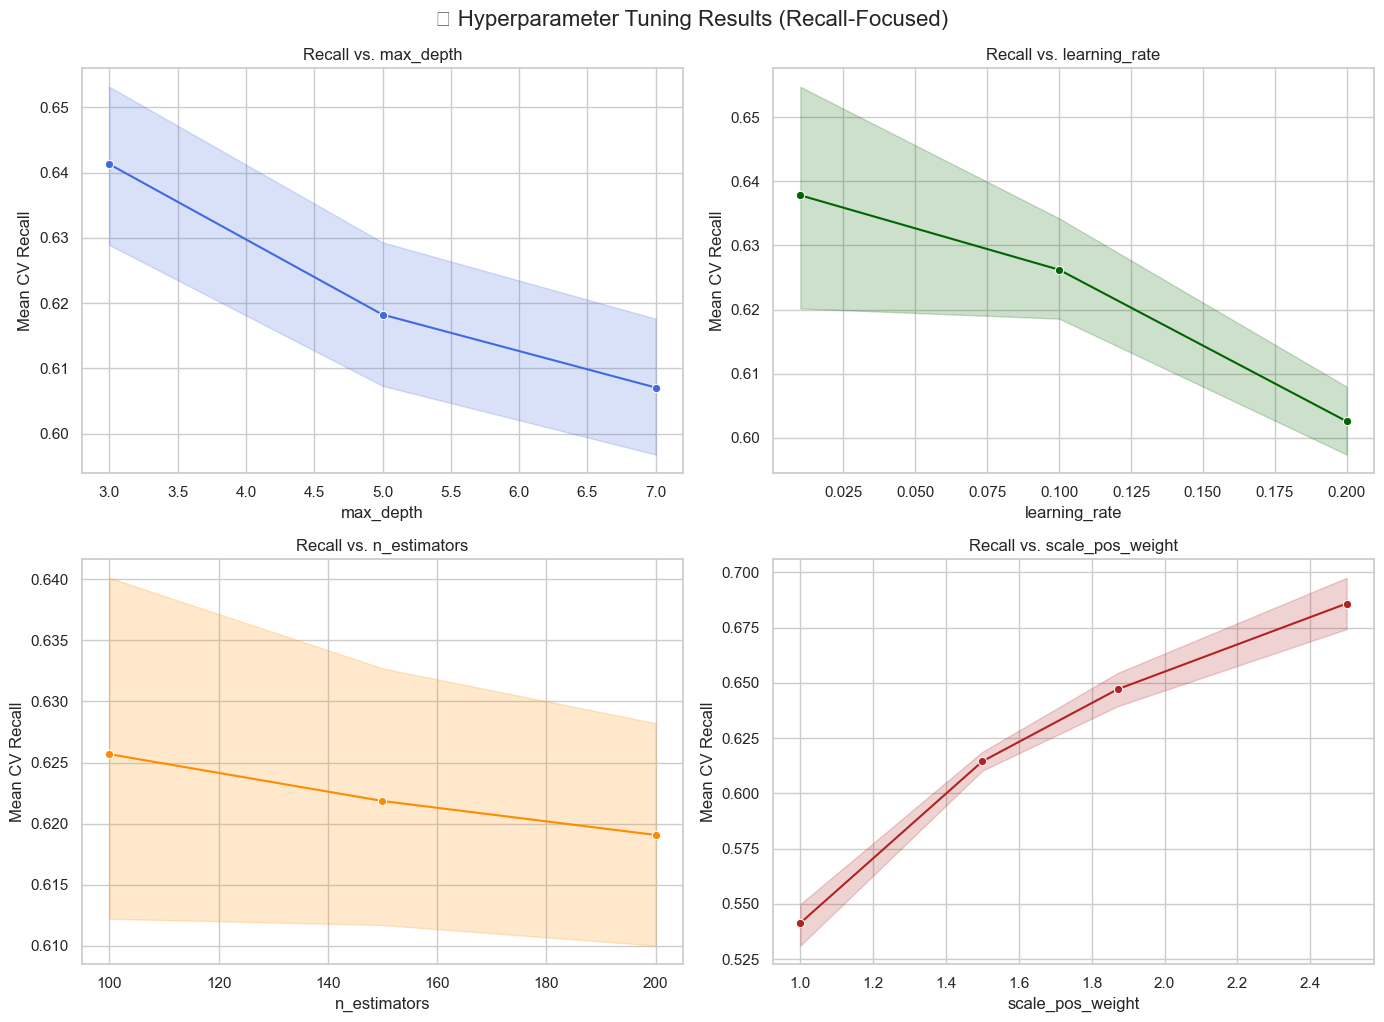

In [149]:
# Convert cv_results_ to DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(14, 10))

# Plot 1: max_depth
plt.subplot(2, 2, 1)
sns.lineplot(data=results_df, x='param_max_depth', y='mean_test_score', marker='o', color='royalblue')
plt.title("Recall vs. max_depth")
plt.xlabel("max_depth")
plt.ylabel("Mean CV Recall")

# Plot 2: learning_rate
plt.subplot(2, 2, 2)
sns.lineplot(data=results_df, x='param_learning_rate', y='mean_test_score', marker='o', color='darkgreen')
plt.title("Recall vs. learning_rate")
plt.xlabel("learning_rate")
plt.ylabel("Mean CV Recall")

# Plot 3: n_estimators
plt.subplot(2, 2, 3)
sns.lineplot(data=results_df, x='param_n_estimators', y='mean_test_score', marker='o', color='darkorange')
plt.title("Recall vs. n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Mean CV Recall")

# Plot 4: scale_pos_weight
plt.subplot(2, 2, 4)
sns.lineplot(data=results_df, x='param_scale_pos_weight', y='mean_test_score', marker='o', color='firebrick')
plt.title("Recall vs. scale_pos_weight")
plt.xlabel("scale_pos_weight")
plt.ylabel("Mean CV Recall")

plt.tight_layout()
plt.suptitle("📈 Hyperparameter Tuning Results (Recall-Focused)", fontsize=16, y=1.02)
plt.show()


As we can see in the four graphs above, which represent the results of tuning our hyperparameters (focusing on Recall), we can observe that as we increase both the value of <b>max_depth</b>, as well as our <b>learning_rate</b>, and the <b>n_estimators</b>, we obtain a reduction in the average on the <b>CV Recall</b>. 
On the other hand, as we increment the <b>scale_pos_weight</b> value, we get an increase in our average <b>CV Recall</b>. Therefore, we can infer that the <b><i>hyperparameter scale_pos_weight</b></i> represents the greatest gain in <b>Recall</b> when we adjust it to higher values.

#### Bar Plot for Key Metrics Representation (Better Readbility)

/var/folders/1j/jpfyj3rs4nv6n17cprwxw5n40000gn/T/ipykernel_10785/870077686.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')


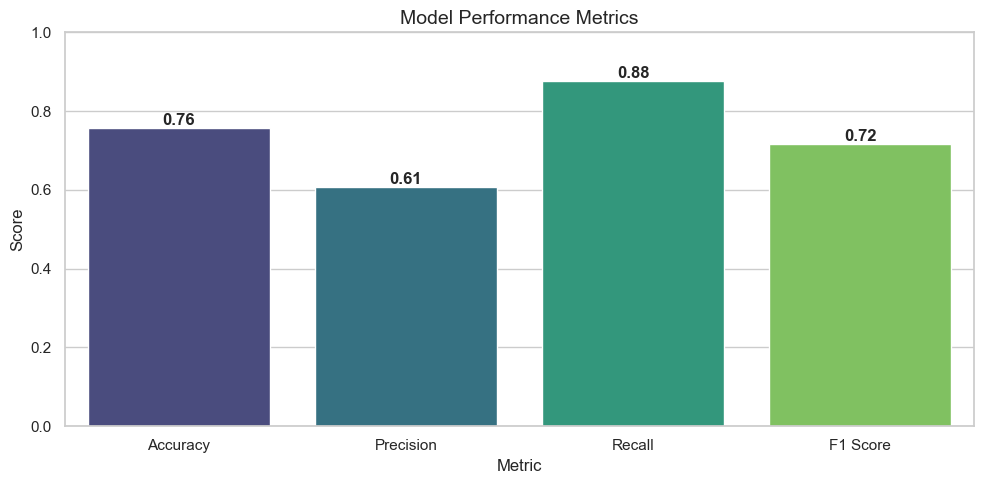

In [150]:
# Plot
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
bars = sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')

# Labeling all the metrics
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{height:.2f}', 
                  (bar.get_x() + bar.get_width() / 2, height), 
                  ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylim(0, 1)
plt.title("Model Performance Metrics", fontsize=14)
plt.ylabel("Score")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()

#### Key Metrics Interpretation:

<b>Accuracy:</b> A 76% overrall correctness of the model across all predictions;<br>
<b>Precision:</b> A 61% among those flagged as diabetic, where 61% are truly at risk of getting diabetes;<br>
<b>Recall:</b> The model correctly identifies 88% of diabetes cases, this is critical for early detection;<br>
<b>F1 Score:</b> 72% balanced performance between catching diabetics and avoiding false alarms cases.<br>

We prioritized the <b>recall</b> metric when applied in the prediction model with the intention of minimize the risk of missing diabetic individuals, a important concern in healthcare, instead of prioritize the <b>accuracy</b> metric.

### Graph Plot for Showing the True Positives and Negatives vs. False Positives and Negatives (For better interpretation)

<Figure size 1000x800 with 0 Axes>

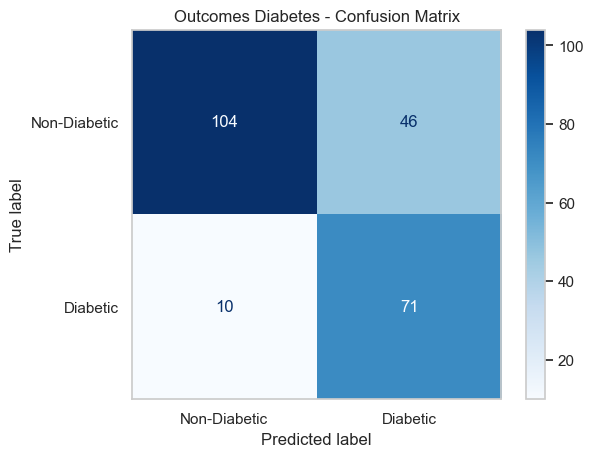

In [151]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Diabetic', 'Diabetic'])

# Plot
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title("Outcomes Diabetes - Confusion Matrix")
plt.grid(False)
plt.show()

Based on the confusion matrix we can see that the dataset is moderately imbalanced, common usually when dealing with health data. <br>

- High <b>true positives</b> (bottom-right) - correctly predicts diabetic cases <br>
- High <b>true negatives</b> (top-left) - correctly predicts non-diabetics cases <br>
- Low <b>false positives</b> (top-right) - avoids wrongly flagging non-diabetes cases <br>
- Low <b>false negatives</b> (bottom-left) - avoids missing actual diabetes cases <br> <br>

|               | Predicted Non-Diabetic     | Predicted Diabetic      |
| ------------- | :-------------: | :-------------: |
**Actual Non-Diabetic** | 104 (✅ True Negative) | 46 (❌ False Positive) |
**Actual Diabetic** | 10 (❌ False Negative) | 71 (✅ True Positive) |

<br>

✅  XGBoost Strengths on Prediction Diabetics/Non-Diabetics:

- High recall for diabetics: <i>71 out of 81 diabetics were correctly identified</i> → <b>Recall = 0.88</b>

- Low false negatives: <i>Only 10 diabetics were missed</i> → great for medical screening

⚠️  XGBoost Weaknesses when Prediction Diabetics/Non-Diabetics:

 - Moderate false positives: <i>46 non-diabetics were incorrectly flagged as diabetic</i> → this lowers precision

 - Precision trade-off: <i>Of all predicted diabetics, a significant portion were actually non-diabetic</i>


We can consider this XGBoost model excellent at catching diabetics (<i>high recall</i>), it sacrifices some precision by flagging more non-diabetics, but in overall this is a clinically safe model for screening—better to flag and follow up than to miss cases.


In [152]:
print(df['Outcome'].value_counts(normalize=True))

Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


As we can see based on the value counts of the dataset, we have about 65% of non-diabetic cases and about 35% of diabetic cases, that seems the dataset is mildly imbalanced.<br>
Also to refer that we apply the stratified splitting on this for getting more good balanced model.

### Graph Plot [<b>ROC Curve</b>] for Positive (Diabetic) and Negative (Non-Diabetic) (Showing Model's Diagnostic Ability)

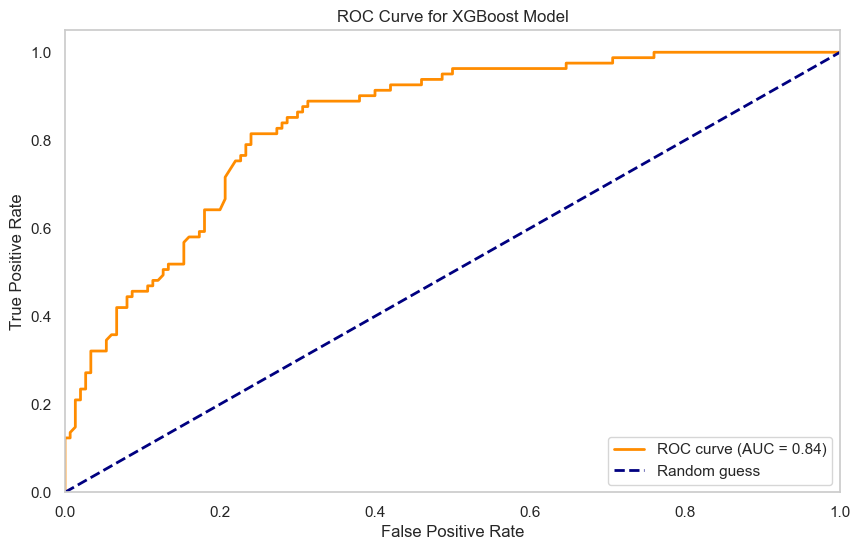

In [153]:
# Predict probabilities instead of binary output (Get Probabilities for Class 1)
y_scores = grid_search.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc_xgb = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc_xgb:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for XGBoost Model")
plt.legend(loc="lower right")
plt.grid()
plt.show()

As we can see on the <b>ROC Curve</b> Graph Plot above, the closer the curve hugs the top-left corner, the better is the model (what is this case), that tell us a good insight that this model is being good on predict.

The <b>AUC (Area Under Cover)</b> scores is equal to 0.84, that tells us a good overall performance, because the score is <b><i>greater than 0.6 and less that 1.0 (reference range values)</b></i>.

# 3. feedforward ANN - Artificial Neural Network Development

#### Imports for Tensorflow libraries

In [154]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from sklearn.metrics import precision_recall_curve, average_precision_score, matthews_corrcoef

print(tf.__version__)

2.19.0


#### Replacing invalid zeros with NaN

In [155]:
# Replace invalid zeros with NaN
features_with_invalid_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[features_with_invalid_zeros] = df[features_with_invalid_zeros].replace(0, np.nan)

In [156]:
# Count zeros in each of those columns
missing_counts = (df[cols_with_missing_zeros] == 0).sum()

# Display the possible missing values
print("🔍 KNN Imputer Possible Missing Values (zeros):")
print(missing_counts)

🔍 KNN Imputer Possible Missing Values (zeros):
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64


### Correlation Matrix for the dataset - goal to understand how features relate to each other and with your target variable (outcome)

/var/folders/1j/jpfyj3rs4nv6n17cprwxw5n40000gn/T/ipykernel_10785/3049895855.py:8: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


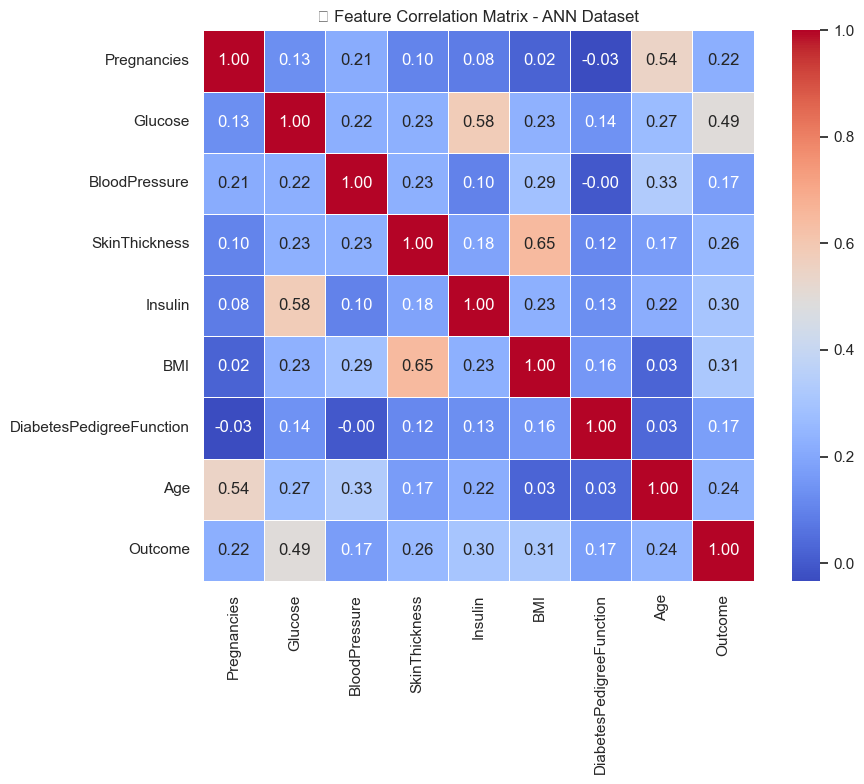

In [157]:
# Get the Correlation Matrix based on the df with the cleaned missing values (ANN)
corr_matrix_ann = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_ann, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("🔍 Feature Correlation Matrix - ANN Dataset")
plt.tight_layout()
plt.show()

After applying the <b>Median Imputation</b> (applied above on the XGBoost model) and <b>KNN Imputer</b> techniques and draw the two correlation matrix we can see that they are balanced, but on the KNN Inputer we get strong correlation between the features <b><i>Insulin vs. Glucose</b></i> and also better compared with the Median Imputation for the features <b><i>BMI vs. SkinThickness</b></i> on the other hand we get a correlation equal between the features <b><i>Age vs. Pregnancies</b></i>.

#### Train-test split (with stratify=y, to preserve class balance) for ANN dataset (before scaling) and also apply KNN Inputation
#### Dataset cleaned with the application of KNN Imputer (to fix missing values on the features: Glucose, BloodPressure, SkinThickness, Insulin and BMI) only applied on ANN (Artificial Neural Networks)
#### Apply KNN Imputer (preserves feature relationships) on the dataset only to use for training ANN

In [158]:
# Separate features and target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Split before scaling or imputation
X_train, X_test, y_train, y_test_ann = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Apply KNN imputation (fit only on training data)
imputer = KNNImputer(n_neighbors=5)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

### Feature Scaling (Normalize features - important for ANN, fit only on Training Data)

In [159]:
# Apply feature scaling (fit only on training data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [160]:
# Check the shape of the splits (Train and Test)
print(f"Training set size: {X_train_scaled.shape[0]} samples")
print(f"Test set size: {X_test_scaled.shape[0]} samples\n")
print(f"Training Outcome distribution:\n{y_train.value_counts(normalize=True)}\n")
print(f"Test Outcome distribution:\n{y_test_ann.value_counts(normalize=True)}")

Training set size: 614 samples
Test set size: 154 samples

Training Outcome distribution:
Outcome
0    0.651466
1    0.348534
Name: proportion, dtype: float64

Test Outcome distribution:
Outcome
0    0.649351
1    0.350649
Name: proportion, dtype: float64


#### Build and define the architecture of the Artificial Neural Network (ANN)

In [161]:
# Build ANN (Artificial Neural Network) model
model = Sequential([
    Dense(128, input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),
    
    Dense(64),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    
    Dense(32),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')  # Binary classification
])

# Handle Class Imbalance
# Using class_weight to emphasize the minority class aka diabetics
ann_class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_test_ann),
    y=y_test_ann
)
# define dict struct to apply this later on the parameter when fit the model
ann_class_weights_dict = dict(enumerate(ann_class_weights))

# Focal Loss
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, 'float32')
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        return -K.mean(alpha * K.pow(1. - pt, gamma) * K.log(pt))
    return loss

# Optimizer using smaller learning rate
optimizer = Adam(learning_rate=0.0003) #3

# compile the model
model.compile(optimizer=optimizer, loss=focal_loss(), metrics=['Precision', 'Recall'])

# Callbacks
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_recall', mode='max', patience=10, restore_best_weights=True)
# Apply the ReduceLROPlateau (using these callbacks) help better converge the model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)


# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    class_weight=ann_class_weights_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Precision: 0.4134 - Recall: 0.2433 - loss: 0.0734 - val_Precision: 0.7429 - val_Recall: 0.5909 - val_loss: 0.0366 - learning_rate: 3.0000e-04
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.3454 - Recall: 0.2713 - loss: 0.0642 - val_Precision: 0.7500 - val_Recall: 0.6136 - val_loss: 0.0344 - learning_rate: 3.0000e-04
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.5792 - Recall: 0.4769 - loss: 0.0458 - val_Precision: 0.6923 - val_Recall: 0.6136 - val_loss: 0.0330 - learning_rate: 3.0000e-04
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.5013 - Recall: 0.4564 - loss: 0.0469 - val_Precision: 0.6923 - val_Recall: 0.6136 - val_loss: 0.0322 - learning_rate: 3.0000e-04
Epoch 5/100
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - Precision: 0.4167 - Recall: 0.5556 - loss: 0.0424

/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: Precision,Recall,loss,val_Precision,val_Recall,val_loss
  current = self.get_monitor_value(logs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.5428 - Recall: 0.5408 - loss: 0.0463 - val_Precision: 0.6842 - val_Recall: 0.5909 - val_loss: 0.0316 - learning_rate: 3.0000e-04
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.5774 - Recall: 0.5257 - loss: 0.0486 - val_Precision: 0.7027 - val_Recall: 0.5909 - val_loss: 0.0308 - learning_rate: 3.0000e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.5337 - Recall: 0.4891 - loss: 0.0460 - val_Precision: 0.7027 - val_Recall: 0.5909 - val_loss: 0.0302 - learning_rate: 3.0000e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6193 - Recall: 0.6045 - loss: 0.0384 - val_Precision: 0.6842 - val_Recall: 0.5909 - val_loss: 0.0298 - learning_rate: 3.0000e-04
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.6270 - Recall: 0.5365 - loss: 0.0390 - val_Precision: 0.6842 - val_Recall: 0.5909 - val_loss: 0.0296 - learning_rate: 3.0000e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━

## Evaluate the ANN

In [162]:
# Predict probabilities with Tuned Threshold and convert to binary
y_scores_ann = model.predict(X_test_scaled).flatten()
y_pred_ann = (y_scores_ann >= 0.42).astype(int) # Lower threshold to boost recall

# Metrics
ann_accuracy = accuracy_score(y_test_ann, y_pred_ann)
ann_precision = precision_score(y_test_ann, y_pred_ann)
ann_recall = recall_score(y_test_ann, y_pred_ann)
ann_f1score = f1_score(y_test_ann, y_pred_ann)

print("Artificial Neural Network - Metrics Evaluation:\n")
print(f"✅ Accuracy:  {ann_accuracy:.4f}")
print(f"🎯 Precision: {ann_precision:.4f}")
print(f"🔁 Recall:    {ann_recall:.4f}")
print(f"📏 F1 Score:  {ann_f1score:.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_test_ann, y_pred_ann, target_names=["Non-Diabetic", "Diabetic"]))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Artificial Neural Network - Metrics Evaluation:

✅ Accuracy:  0.7013
🎯 Precision: 0.5444
🔁 Recall:    0.9074
📏 F1 Score:  0.6806

📋 Classification Report:
              precision    recall  f1-score   support

Non-Diabetic       0.92      0.59      0.72       100
    Diabetic       0.54      0.91      0.68        54

    accuracy                           0.70       154
   macro avg       0.73      0.75      0.70       154
weighted avg       0.79      0.70      0.71       154



In [163]:
print(history.history.keys())

dict_keys(['Precision', 'Recall', 'loss', 'val_Precision', 'val_Recall', 'val_loss', 'learning_rate'])


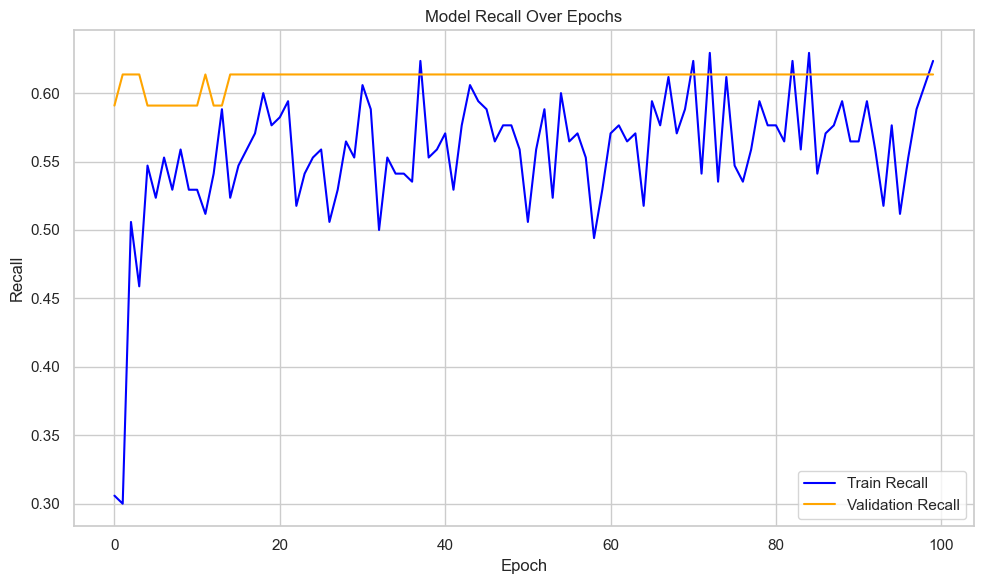

In [164]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['Recall'], label='Train Recall', color='blue')
plt.plot(history.history['val_Recall'], label='Validation Recall', color='orange')
plt.title('Model Recall Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🔵 <b>Train Recall</b>	- Fluctuates heavily between <b><i>~0.475 and 0.675</b></i> across all 100 epochs <br>
🟠 <b>Validation Recall</b>	- Stabilizes around <b><i>0.625</b></i> after ~epoch 20 and stays flat

✅ 1. Validation Recall is Stable:

 - After some early fluctuations, your validation recall locks in at <b>~0.625</b>

 - This model is generalizing consistently to unseen data;

- No signs of overfitting and seems to be a good factor;

⚠️ 2. Training Recall is Noisy:

The blue line jumps up and down across epochs (some noisy on training)

Likely issues:

 - This model is sensitive to batch composition;

 - Possibly still a bit of learning rate instability and somehow is struggling to consistently learn from the training data.

Seems that validation recall is stable and trustworthy — a great sign of generalization, also the training recall is still noisy, but that’s manageable.

### ANN - Confusion Matrix for Negative vs. Positives cases

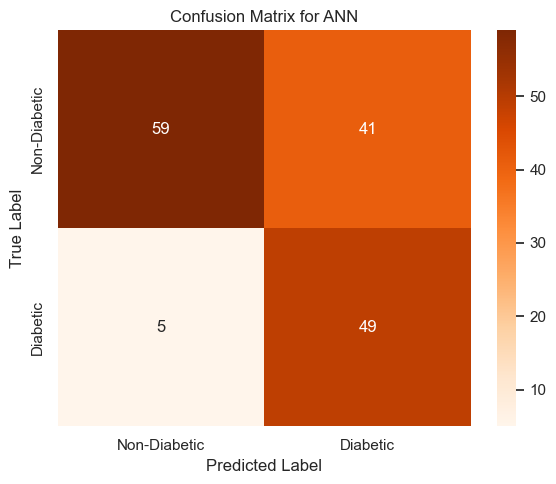

In [165]:
# Generate confusion matrix
cm = confusion_matrix(y_test_ann, y_pred_ann)
labels = ["Non-Diabetic", "Diabetic"]

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for ANN")
plt.tight_layout()
plt.show()


|               | Predicted Non-Diabetic     | Predicted Diabetic      |
| ------------- | :-------------: | :-------------: |
**Actual Non-Diabetic** | 59 (✅ True Negative) | 41 (❌ False Positive) |
**Actual Diabetic** | 6 (❌ False Negative) | 48 (✅ True Positive) |

<br>

✅  ANN Strengths on Prediction Diabetics/Non-Diabetics:

- High recall for diabetics: <i>49 out of 54 diabetics were correctly identified</i> → <b>Recall = 0.90</b>

- Low false negatives: <i>Only 5 diabetics were missed</i> → great for medical screening

⚠️  ANN Weaknesses when Prediction Diabetics/Non-Diabetics:

 - Moderate false positives: <i>41 non-diabetics were incorrectly flagged as diabetic</i> → this lowers precision

 - Precision trade-off: <i>Of all predicted diabetics, a significant portion were actually non-diabetic</i>


We can consider that this ANN is excellent at catching diabetics (<i>high recall</i>), it sacrifices some precision by flagging more non-diabetics, but in overall this is a clinically safe model for screening-better to flag and follow up than to miss cases.


### ANN - Precision-Recall Curve

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


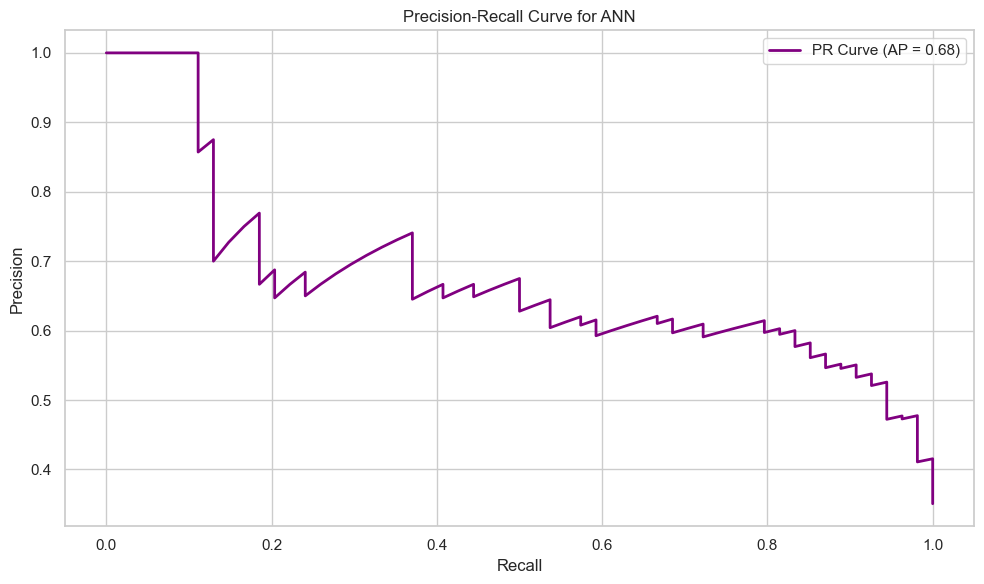

In [166]:
y_scores_ann = model.predict(X_test_scaled).flatten()
precision, recall, _ = precision_recall_curve(y_test_ann, y_scores_ann)
avg_precision = average_precision_score(y_test_ann, y_scores_ann)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {avg_precision:.2f})', color='purple', linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for ANN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The Precision-Recall Curve give us the <b>Average Precision (AP)</b> value that summarizes the area under the <b>Precision-Recall Curve</b>, it reflects how well your model balances <b>precision and recall</b> across all thresholds.
In this case we got a <b>AP = 0.68</b> value, that means this model maintains a reasonable trade-off between catching diabetics (<b>recall</b>) and avoiding false alarms cases (<b>precision</b>). 

<b>The AP Score Range when:</b> <br> <br>
<i><b>is less than 0.60</i></b> - tell us that the neural network need more improvement; <br> 
<i><b>0.60 - 0.74</i></b> - the neural network is moderate to good; <br>
<i><b>0.75 - 0.89</i></b> - the neural network is strong performance; <br>
<i><b>0.90-1.00</i></b> - the neural network is excellent.

In your case we get a value of <b>0.68</b>, we can consider as a <b>solid value</b> especially because the <b>recall value</b> in this case is <b>high (about 0.90)</b>, especially because this is small dataset (768 samples), the classes are <b>imbalanced</b> and the <b>ANN</b> aren't naturally optimized for tabular data unlike the traditional <b>ML algorithms.</b>

### ANN - F1 Score

In [167]:
f1 = f1_score(y_test_ann, y_pred_ann)
print(f"ANN F1 Score: {f1:.4f}")

ANN F1 Score: 0.6806


### ANN - Matthews Correlation Coefficient (MCC)

In [168]:
mcc = matthews_corrcoef(y_test_ann, y_pred_ann)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

Matthews Correlation Coefficient (MCC): 0.4816


The MCC gives us a single, balanced score that reflects the quality of your predictions, it’s especially valuable when class imbalance is present (like this case), and we can consider a great complement to F1 score and Confusion Matrix in terms of getting a correlation coefficient between the observed and predicted classifications (Diabetics vs. Non-Diabetics), this return a value between <b>-1 and 1</b>.

<b>MCC Range values:</b>

| MCC Range	  | Interpretation |
| :-------------: | :-------------: |
+1.0	   | Perfect prediction ✅
0.7 – 0.9. | Strong correlation 💪
0.4 – 0.7  | Moderate correlation 👍
0.2 – 0.4  | Weak correlation ⚠️
0.0 – 0.2  | Very weak or random ❓
< 0.0	   | Worse than random ❌

In your case we got a value of <b>0.4816</b> that falls into the <b>moderate correlation</b> range.
This means that your ANN model is meaningfully better than random (<b>catching diabetics</b> with reasonable trade-offs between false positives and false negatives), it’s making balanced predictions across both classes and it’s especially impressive given the <i>class imbalance and your focus on high recall</i>.

### 🧠 SHAP Summary Plot for ANN

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step


  1%|          | 1/100 [00:00<00:36,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


  2%|▏         | 2/100 [00:00<00:35,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


  3%|▎         | 3/100 [00:01<00:34,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


  4%|▍         | 4/100 [00:01<00:34,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


  5%|▌         | 5/100 [00:01<00:34,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


  6%|▌         | 6/100 [00:02<00:33,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


  7%|▋         | 7/100 [00:02<00:33,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


  8%|▊         | 8/100 [00:02<00:33,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


  9%|▉         | 9/100 [00:03<00:32,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


 10%|█         | 10/100 [00:03<00:32,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


 11%|█         | 11/100 [00:03<00:32,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


 12%|█▏        | 12/100 [00:04<00:31,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


 13%|█▎        | 13/100 [00:04<00:31,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


 14%|█▍        | 14/100 [00:05<00:30,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


 15%|█▌        | 15/100 [00:05<00:30,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


 16%|█▌        | 16/100 [00:05<00:30,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


 17%|█▋        | 17/100 [00:06<00:29,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


 18%|█▊        | 18/100 [00:06<00:29,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


 19%|█▉        | 19/100 [00:06<00:29,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


 20%|██        | 20/100 [00:07<00:28,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


 21%|██        | 21/100 [00:07<00:28,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


 22%|██▏       | 22/100 [00:07<00:27,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


 23%|██▎       | 23/100 [00:08<00:31,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step


 24%|██▍       | 24/100 [00:08<00:30,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


 25%|██▌       | 25/100 [00:09<00:29,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


 26%|██▌       | 26/100 [00:09<00:28,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


 27%|██▋       | 27/100 [00:09<00:27,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


 28%|██▊       | 28/100 [00:10<00:26,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


 29%|██▉       | 29/100 [00:10<00:26,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


 30%|███       | 30/100 [00:11<00:25,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


 31%|███       | 31/100 [00:11<00:25,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


 32%|███▏      | 32/100 [00:11<00:24,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step


 33%|███▎      | 33/100 [00:12<00:24,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


 34%|███▍      | 34/100 [00:12<00:23,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step


 35%|███▌      | 35/100 [00:12<00:23,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


 36%|███▌      | 36/100 [00:13<00:22,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


 37%|███▋      | 37/100 [00:13<00:22,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


 38%|███▊      | 38/100 [00:13<00:22,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


 39%|███▉      | 39/100 [00:14<00:21,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


 40%|████      | 40/100 [00:14<00:21,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step


 41%|████      | 41/100 [00:14<00:21,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


 42%|████▏     | 42/100 [00:15<00:20,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step


 43%|████▎     | 43/100 [00:15<00:20,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step


 44%|████▍     | 44/100 [00:16<00:19,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


 45%|████▌     | 45/100 [00:16<00:19,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step


 46%|████▌     | 46/100 [00:16<00:19,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


 47%|████▋     | 47/100 [00:17<00:18,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


 48%|████▊     | 48/100 [00:17<00:18,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


 49%|████▉     | 49/100 [00:17<00:18,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


 50%|█████     | 50/100 [00:18<00:17,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


 51%|█████     | 51/100 [00:18<00:17,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


 52%|█████▏    | 52/100 [00:18<00:17,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


 53%|█████▎    | 53/100 [00:19<00:16,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


 54%|█████▍    | 54/100 [00:19<00:16,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


 55%|█████▌    | 55/100 [00:19<00:16,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


 56%|█████▌    | 56/100 [00:20<00:15,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step


 57%|█████▋    | 57/100 [00:20<00:15,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


 58%|█████▊    | 58/100 [00:21<00:14,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


 59%|█████▉    | 59/100 [00:21<00:14,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


 60%|██████    | 60/100 [00:21<00:14,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


 61%|██████    | 61/100 [00:22<00:13,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


 62%|██████▏   | 62/100 [00:22<00:13,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


 63%|██████▎   | 63/100 [00:22<00:13,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


 64%|██████▍   | 64/100 [00:23<00:12,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


 65%|██████▌   | 65/100 [00:23<00:12,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


 66%|██████▌   | 66/100 [00:23<00:12,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


 67%|██████▋   | 67/100 [00:24<00:11,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step


 68%|██████▊   | 68/100 [00:24<00:11,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


 69%|██████▉   | 69/100 [00:24<00:11,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step


 70%|███████   | 70/100 [00:25<00:10,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step


 71%|███████   | 71/100 [00:25<00:10,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


 72%|███████▏  | 72/100 [00:26<00:09,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


 73%|███████▎  | 73/100 [00:26<00:09,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


 74%|███████▍  | 74/100 [00:26<00:09,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


 75%|███████▌  | 75/100 [00:27<00:09,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


 76%|███████▌  | 76/100 [00:27<00:08,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step


 77%|███████▋  | 77/100 [00:27<00:08,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step


 78%|███████▊  | 78/100 [00:28<00:07,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


 79%|███████▉  | 79/100 [00:28<00:07,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


 80%|████████  | 80/100 [00:28<00:07,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


 81%|████████  | 81/100 [00:29<00:06,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


 82%|████████▏ | 82/100 [00:29<00:06,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


 83%|████████▎ | 83/100 [00:29<00:06,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


 84%|████████▍ | 84/100 [00:30<00:05,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


 85%|████████▌ | 85/100 [00:30<00:05,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


 86%|████████▌ | 86/100 [00:31<00:05,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


 87%|████████▋ | 87/100 [00:31<00:04,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


 88%|████████▊ | 88/100 [00:31<00:04,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


 89%|████████▉ | 89/100 [00:32<00:03,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


 90%|█████████ | 90/100 [00:32<00:03,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


 91%|█████████ | 91/100 [00:32<00:03,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step


 92%|█████████▏| 92/100 [00:33<00:02,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


 93%|█████████▎| 93/100 [00:33<00:02,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step


 94%|█████████▍| 94/100 [00:33<00:02,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


 95%|█████████▌| 95/100 [00:34<00:01,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


 96%|█████████▌| 96/100 [00:34<00:01,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


 97%|█████████▋| 97/100 [00:34<00:01,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


 98%|█████████▊| 98/100 [00:35<00:00,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


 99%|█████████▉| 99/100 [00:35<00:00,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


100%|██████████| 100/100 [00:36<00:00,  2.77it/s]


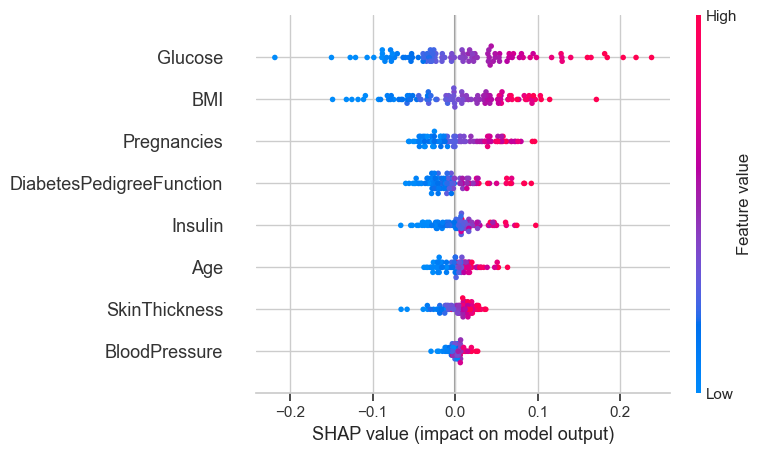

In [169]:
# Define a prediction function
def model_predict(X):
    return model.predict(X).flatten()

# Use a small background sample for SHAP
X_background = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)]

# Create the explainer
explainer = shap.KernelExplainer(model_predict, X_background)

# Compute SHAP values for a subset of test data
X_sample = X_test_scaled[:100]
shap_values = explainer.shap_values(X_sample)

# Plot summary
shap.summary_plot(shap_values, X_sample, feature_names=X.columns.tolist())


This plot above shows how each feature influences the model's predictions across all samples in this case when we apply the XGBoost model.
The Y-axis shows the features ranked by importance, where the features that appear on the top are the most impactful and on the X-axis we got the <b>SHAP values</b> that have impact on the model, where <b><i>values > 0</b></i> pushes the prediction toward <u>diabetic</u> and <b><i>values < 0</b></i> pushes prediction toward <u>non-diabetic</u>, also the <i>red color represent high feature value and blue ones shows the lowest feature values</i>.

<b>Feature Interpretation:</b>

1. Glucose (most impactful)

 - 🔴 High glucose → strongly pushes prediction toward diabetic (right)

 - 🔵 Low glucose → pushes prediction toward non-diabetic (left)

 - ✅ This aligns perfectly with medical knowledge

2. BMI
 - High BMI (red) increases diabetes risk prediction;

 - Low BMI (blue) reduces it;

 - Again, this is medically consistent.

3. Pregnancies

 - More pregnancies (red) slightly increase the prediction;

 - Lower values (blue) have a neutral or negative effect.

4. Insulin

 - Mixed influence: some high values push right, others left;

 - Suggests nonlinear or interaction effects how this ANN is capturing complexity here.

5. DiabetesPedigreeFunction

 - Higher values (red) tend to push predictions toward diabetic;

 - Reflects genetic predisposition.

6. Age

 - Older age (red) increases risk;

 - Younger age (blue) decreases it.

7. SkinThickness and BloodPressure

 - Less impactful overall (shorter spread on x-axis);

 - Still contribute, but not as strongly.


🔴  High <b>glucose, BMI, and age</b> push predictions toward diabetic

🔵  Low values of these features push toward non-diabetic

This <b>ANN</b> behaves and making decisions aligned with medical reasoning.



In [177]:
# Validate if the test and the scores on ANN have the same number of samples
print(y_test_ann.shape)
print(y_scores_ann.shape)

(154,)
(154,)


In [171]:
# Get predicted probabilities from your ANN
y_pred_proba_ann = model.predict(X_test_scaled).flatten()

# Compute ROC AUC
roc_auc_ann = roc_auc_score(y_test_ann, y_pred_proba_ann)
print(f"🔵 ROC AUC for ANN: {roc_auc_ann:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
🔵 ROC AUC for ANN: 0.8135


/var/folders/1j/jpfyj3rs4nv6n17cprwxw5n40000gn/T/ipykernel_10785/1820432525.py:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


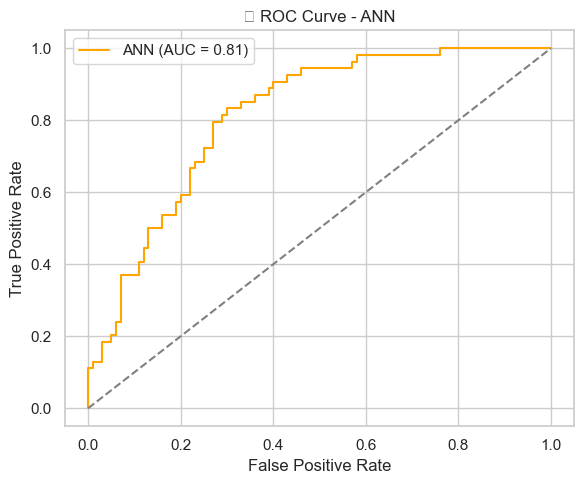

In [172]:
# Calculate the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_ann, y_pred_proba_ann)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ANN (AUC = {roc_auc_ann:.2f})", color="orange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve - ANN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


We apply ROC AUC (Receiver Operating Characteristic – Area Under the Curve) to evaluates how well the model separates the two classes across all possible thresholds, measures the model ability to distinguish between classes (Diabetic vs. Non-Diabetic) across all thresholds.

We got a score about <b>0.81</b>, this means that, on average, the <i>ANN ranks a randomly chosen diabetic patient <b>higher</b> than a randomly chosen non-diabetic patient <b>84% of the time</b></i>, this range lands in the <b>Very Good</b> range by convention. 

As we can see, <i>this value is a bit lesser (0.03) that ROC AUC XGBoost model value (about 0.84)</i>, this tells that, this two models are some how equivalent, in terms of how model separates the two classes across all possibles thresholds, but the <b>XGBoost has a slightly higher advantage</b>.

### Side-by-Side Confusion Matrices (ANN vs. XGBoost)

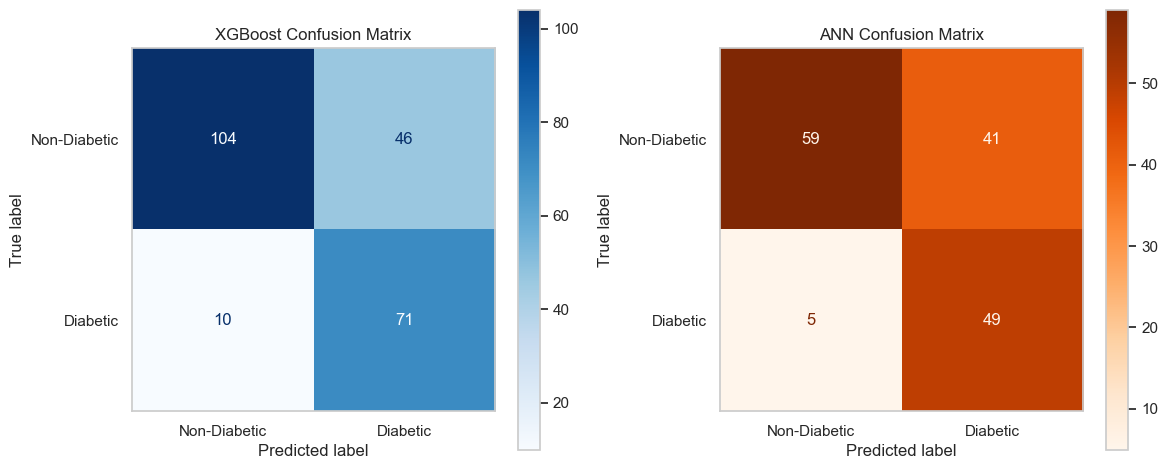

In [173]:
# Compute confusion matrices
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_ann = confusion_matrix(y_test_ann, y_pred_ann)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# XGBoost
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=["Non-Diabetic", "Diabetic"])
disp_xgb.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title("XGBoost Confusion Matrix")
axes[0].grid(False)

# ANN
disp_ann = ConfusionMatrixDisplay(confusion_matrix=cm_ann, display_labels=["Non-Diabetic", "Diabetic"])
disp_ann.plot(ax=axes[1], cmap='Oranges', values_format='d')
axes[1].set_title("ANN Confusion Matrix")
axes[1].grid(False)

plt.tight_layout()
plt.show()

In [174]:
# ANN
precision_ann, recall_ann, _ = precision_recall_curve(y_test_ann, y_scores_ann)
ap_ann = average_precision_score(y_test_ann, y_scores_ann)

# XGBoost
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_scores_xgb)
ap_xgb = average_precision_score(y_test, y_scores_xgb)


/var/folders/1j/jpfyj3rs4nv6n17cprwxw5n40000gn/T/ipykernel_10785/2953784003.py:10: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


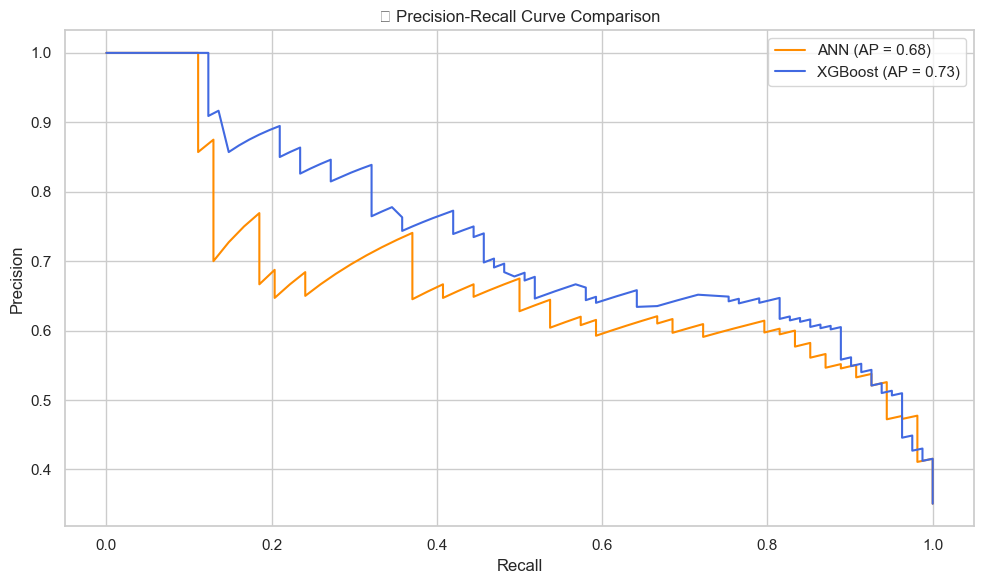

In [175]:
plt.figure(figsize=(10, 6))
plt.plot(recall_ann, precision_ann, label=f'ANN (AP = {ap_ann:.2f})', color='darkorange')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AP = {ap_xgb:.2f})', color='royalblue')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("🔍 Precision-Recall Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Each curve shows how precision and recall trade off as vary the decision threshold.
<br>

| Axis	| Meaning |
| :-----: | :-----: |
| X-axis  |	Recall (how many actual diabetics were correctly identified) |
| Y-axis  |	Precision (how many predicted diabetics were actually correct) |

&
| Model	| Curve Color | Average Precision (AP) | Interpretation |
| :-----: | :-----: | :----------------------: | :------------: |
| **ANN**  |	Orange | **0.68** | Decent, but lower precision at high recall |
| **XGBoost**  |	Blue   | **0.73** | Better balance of precision and recall |

<b>XGBoost</b> dominates this evaluation, it's curve stays above the <b>ANN curve</b> across most recall levels, <i>meaning it maintains higher precision while still catching more diabetic cases.</i>
<u>ANN drops off faster: As recall increases, ANN’s precision drops more sharply—indicating more false positives at high sensitivity.</u>
<b>AP Score: XGBoost’s 0.73 vs. ANN’s 0.68</b> confirms that <u>XGBoost</u> is more effective overall at balancing both metrics.
XGBoost dominates: Its curve stays above the ANN curve across most recall levels, meaning it maintains higher precision while still catching more diabetic cases.

<b>XGBoost is outperforming ANN</b> in terms of precision-recall trade-off, it’s a better choice if we want fewer <i>false positives without sacrificing recall</i>, but we can also consider <b>ANN</b> still performs reasonably well, but <b>XGBoost</b> is more robust across thresholds.

## 4. Comparison and Reflection

### 4.1 Did your ANN overfit? How did you prevent it?

No, the <b><i>ANN did not overfit</b></i>. Although the training recall fluctuated, the validation recall stabilized early and remained consistent. 

<b>Overfitting was prevented using:</b>

 - Dropout layers to reduce neuron co-dependence;

 - Batch normalization to stabilize learning;

 - Early stopping to halt training when validation recall plateaued;

These techniques helped the <b>ANN</b> <i>generalize well without memorizing the training data</i>.

### 4.2 Which technique (batch norm, dropout, etc.) was most helpful?

<b>Dropout</b> and <b>early stopping</b> were the most impactful:

 - <i>Dropout (0.3–0.4)</i> forced the network to learn more robust representations;

 - Early stopping ensured the model <i>didn’t over-train once validation recall plateaued;</i>

<b>Batch normalization</b> also contributed by smoothing the learning process, but <b>Dropout</b> had the clearest effect on generalization.

### 4.3 How would results change with more data?

<b>With more data:</b>

 - Both models would likely improve, but <i>ANN would benefit more;</i>

 - <i>Neural networks thrive on large datasets and could learn deeper patterns;</i>

 - <i>More data would reduce variance, improve recall stability, and potentially boost precision.</i>

In contrast, <b><i>XGBoost already performs well with smaller datasets and might see more modest gains</b></i>.

### 4.4 Which model performed best?

In [176]:
from tabulate import tabulate

# Column headers
metric_headers = ["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]

# Convert from float64 to float (with 4 decimals) for better readbility on table
auc_xgb = round(float(roc_auc_xgb), 4)
auc_ann = round(float(roc_auc_ann), 4)

# data
data = [
    ["XGBoost", metrics["Accuracy"], metrics["Precision"], metrics["Recall"], metrics["F1 Score"], auc_xgb],
    ["ANN", ann_accuracy, ann_precision, ann_recall, ann_f1score, auc_ann]
]

markdown_table = tabulate(data, headers=metric_headers, tablefmt="fancy_grid", floatfmt=".4f", numalign="right")
print(markdown_table)

╒═════════╤════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Model   │   Accuracy │   Precision │   Recall │   F1-Score │   ROC-AUC │
╞═════════╪════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ XGBoost │     0.7576 │      0.6068 │   0.8765 │     0.7172 │    0.8406 │
├─────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│ ANN     │     0.7013 │      0.5444 │   0.9074 │     0.6806 │    0.8135 │
╘═════════╧════════════╧═════════════╧══════════╧════════════╧═══════════╛


 #### Final Thoughts:
 
 - <b><i>XGBoost had better accuracy, precision, F1 score and ROC-AUC</i></b>, making it more reliable overall;

 - <b>ANN had slightly higher recall</b>, which is valuable in medical screening;

 - <b>ANN</b> was well-regularized and didn't overfit;

 - <b>Dropout and early stopping</b> were key to generalization;

 - <i>More data would help <b>ANN</b> take equivalent or surpass the <b>XGBoost</b> performance;</i>

 - If <i>recall is the top priority, ANN is competitive (if we could have in the future a dataset with more data observations)</i> otherwise, <b>XGBoost is the better all-around performer.</b>

 - In overrall <b>XGBoost is at this moment the best performer model</b> in terms of balanced metrics.

 Just one more out-of-the-box possibility:

 - If we want go deeper in getting a better performance, we can also apply <i>ensemble strategies to combine the powerfull of ANN with XGBoost model</i>, that can lead to better generalization and more robust predictions, this is called by convention as <b>heterogeneous ensemble</b>, combining both strengths for better performance and stability.